In [11]:
#LIBRERIE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, Point, LineString
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.gridspec import GridSpec

#_PARAMTERI_____________________________________________________________________________________________________________________________
FONT_DIM = [12, 15, 18, 21, 27]

LUNGHEZZA_RIVELATORE_X = (80, 80, 30) # cm          <- DA IMPOSTARE !!!
LUNGHEZZA_RIVELATORE_Y = (30, 30, 80) # cm          <- DA IMPOSTARE !!!
SPESSORE_RIVELATORE =    (2.5, 4,  4) # cm          <- DA IMPOSTARE !!!

EFFICIENZA_RIVELATORE = (99.1633, 
                         98.9885, 
                         99.1398) # %               <- DA IMPOSTARE !!!

X_RIVELATORE = (0, 0, -25) # cm
Y_RIVELATORE = (0, 0, 50) # cm
Z_RIVELATORE = (SPESSORE_RIVELATORE[0],
                SPESSORE_RIVELATORE[0] +
                SPESSORE_RIVELATORE[1] + 3,
                SPESSORE_RIVELATORE[0] +
                SPESSORE_RIVELATORE[1] + 3 +
                SPESSORE_RIVELATORE[2] + 1) # cm    <- DA IMPOSTARE !!!

#DISTANZA_TRA_FACCE_1_3 = Z_RIVELATORE[2] - SPESSORE_RIVELATORE[2] - Z_RIVELATORE[0] # cm
#print((SPESSORE_RIVELATORE[0]*LUNGHEZZA_RIVELATORE_Y[2]) / DISTANZA_TRA_FACCE_1_3) # cm

SINGOLE_DESIDERATE = 30000 # conteggi

LIM_AREA_GENERAZIONE_EVENTI =   [
                                [-100, 20],  # Intervallo lungo x
                                [-60, 60]    # Intervallo lungo y
                                ]

LARGHEZZA = LIM_AREA_GENERAZIONE_EVENTI[0][1] - LIM_AREA_GENERAZIONE_EVENTI[0][0]
PROFONDITA = LIM_AREA_GENERAZIONE_EVENTI[1][1] - LIM_AREA_GENERAZIONE_EVENTI[1][0]
AREA_GENERAZIONE_EVENTI = LARGHEZZA * PROFONDITA

QUANTI_EVENTI_GENERARE = round((AREA_GENERAZIONE_EVENTI * SINGOLE_DESIDERATE) / (LUNGHEZZA_RIVELATORE_X[0] * LUNGHEZZA_RIVELATORE_Y[0]))

FONT_DIM = [12,15,18,21,27]
MARKER_SIZE = 4
LINE_WIDTH = 1.5
GRID_COLOR = 'lightgray'
GRID_ALPHA = 0.8

COLORI_BIN = ["tab:blue", "tab:red"]
COLORI_DUE = ["tab:blue", "tab:orange"]
COLORI_TRE = ["tab:blue", "tab:green", "tab:red"]
COLORI_ARC = ["tab:purple", "tab:blue", "tab:green", "tab:olive", "tab:orange", "tab:red"]
COLORI_ARC_10 = ["maroon", "tab:red","darkorange" ,"darkgoldenrod", "tab:olive", "tab:green", "teal", "tab:blue", "tab:purple", "darkmagenta"]

CARTELLA_IMMAGINI = "Immagini/"
ESPORTA_IMMGAGINI = True
FORMATO_IMMAGINI = ".pdf"
DPI = 300

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "DejaVu Sans"

#_OGGETTI_______________________________________________________________________________________________________________________________
class Evento:
    def __init__(self, x, y, teta, phi):
        self.x_ori = x
        self.y_ori = y
        self.z_ori = 0
        self.teta = teta      
        self.phi = phi

        # Inizializza le coordinate per i rivelatori
        self.x = []
        self.y = []
        self.z = []

        # Calcola le coordinate per ciascun rivelatore
        for z in Z_RIVELATORE:
            self.x.append(self.x_ori + z * np.tan(self.teta))
            self.y.append(self.y_ori + z * np.tan(self.phi))
            self.z.append(z)

        self.rivelatori_intercettati = []

class Parallelogramma:
    def __init__(self, larghezza, profondità, altezza, x, y, z, efficienza):
        self.x = x
        self.y = y
        self.z = z
        self.larghezza = larghezza
        self.profondità = profondità
        self.altezza = altezza
        self.efficienza = efficienza

        self.coord_x = [self.x, 
                        self.x - self.larghezza,
                        self.x - self.larghezza,
                        self.x,
                        self.x]
        self.coord_y = [self.y, 
                        self.y,
                        self.y - self.profondità,
                        self.y - self.profondità,
                        self.y]

#_FUNZIONI______________________________________________________________________________________________________________________________
def CalcolaOmbra (parallelogramma, evento):
    if evento.teta <= 0 and evento.phi > 0:
        coord = [
                (parallelogramma.x, 
                parallelogramma.y),

                (parallelogramma.x, 
                parallelogramma.y - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza, 
                parallelogramma.y - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza + parallelogramma.altezza * np.tan(evento.teta),
                parallelogramma.y - parallelogramma.profondità + parallelogramma.altezza * np.tan(evento.phi)),

                (parallelogramma.x - parallelogramma.larghezza + parallelogramma.altezza * np.tan(evento.teta),
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta),
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),
                ]
    elif evento.teta < 0 and evento.phi <= 0:
        coord = [
                (parallelogramma.x, 
                parallelogramma.y),

                (parallelogramma.x, 
                parallelogramma.y - parallelogramma.profondità),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta), 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.profondità),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta) - parallelogramma.larghezza, 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.profondità),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta) - parallelogramma.larghezza,
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),

                (parallelogramma.x - parallelogramma.larghezza,
                parallelogramma.y),
                ]
    elif evento.teta > 0 and evento.phi >= 0:
        coord = [
                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta), 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta), 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.profondità),

                (parallelogramma.x, 
                parallelogramma.y - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza, 
                parallelogramma.y  - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza,
                parallelogramma.y),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta) - parallelogramma.larghezza,
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),
                ]
    else: #evento.teta > 0 & evento.phi < 0:
        coord = [
                (parallelogramma.x, 
                parallelogramma.y),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta),
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi)),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta), 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.profondità),

                (parallelogramma.x + parallelogramma.altezza * np.tan(evento.teta) - parallelogramma.larghezza, 
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza,
                parallelogramma.y - parallelogramma.profondità),

                (parallelogramma.x - parallelogramma.larghezza,
                parallelogramma.y + parallelogramma.altezza * np.tan(evento.phi) - parallelogramma.altezza * np.tan(evento.phi)),
                ]
    return Polygon(coord)

# Funzione di probabilità: cos^n(x)         <- DA IMPOSTARE !!!
def DistribuzioneAngolare(x, n):
    return np.cos(x) ** n

# Generatore casuale basato su cos^n(x)
def GeneraAngolo(n):
    while True:
        x = np.random.uniform(-np.pi/2, np.pi/2)
        y = np.random.uniform(0, 1)
        if y <= DistribuzioneAngolare(x, n):
            return x


In [10]:
#_VARIABILI_____________________________________________________________________________________________________________________________
SingolePerRivelatore = [0, 0, 0]
DoppiePerRivelatore = [0, 0, 0]
Triple = 0

#_MAIN__________________________________________________________________________________________________________________________________  
# Creazione dei tre rivelatori
Rivelatori = []
for i in range(3):
    Rivelatore = Parallelogramma(
                                larghezza=LUNGHEZZA_RIVELATORE_X[i], 
                                profondità=LUNGHEZZA_RIVELATORE_Y[i], 
                                altezza=SPESSORE_RIVELATORE[i],
                                x=X_RIVELATORE[i],
                                y=Y_RIVELATORE[i],
                                z=Z_RIVELATORE[i],
                                efficienza=EFFICIENZA_RIVELATORE[i]
                                )
    Rivelatori.append(Rivelatore)

# Generazione degli eventi
Eventi = []
for _ in range(QUANTI_EVENTI_GENERARE):
    # Genera valori casuali per x, y, teta, phi
    x = np.random.uniform(*LIM_AREA_GENERAZIONE_EVENTI[0])
    y = np.random.uniform(*LIM_AREA_GENERAZIONE_EVENTI[1])
    teta = GeneraAngolo(2) # np.random.normal(-np.pi/2, np.pi/2)
    phi = GeneraAngolo(2) # np.random.uniform(-np.pi/2, np.pi/2)
    
    EventoInEsame = Evento(x, y, teta, phi)

    for iRivelatore in range(3):
        OmbraRivelatore = CalcolaOmbra(Rivelatori[iRivelatore], EventoInEsame)
        PuntoPassaggioEvento = Point(EventoInEsame.x[iRivelatore], EventoInEsame.y[iRivelatore])
        Efficienza = np.random.uniform(0, 100) < EFFICIENZA_RIVELATORE[iRivelatore]
        PuntoInterno = OmbraRivelatore.contains(PuntoPassaggioEvento) and Efficienza

        if PuntoInterno:
            SingolePerRivelatore[iRivelatore] += 1

        EventoInEsame.rivelatori_intercettati.append(PuntoInterno)   

    if EventoInEsame.rivelatori_intercettati[1] and EventoInEsame.rivelatori_intercettati[2]:
        DoppiePerRivelatore[0] += 1

    if EventoInEsame.rivelatori_intercettati[0] and EventoInEsame.rivelatori_intercettati[2]:
        DoppiePerRivelatore[1] += 1

    if EventoInEsame.rivelatori_intercettati[0] and EventoInEsame.rivelatori_intercettati[1]:
        DoppiePerRivelatore[2] += 1

    if EventoInEsame.rivelatori_intercettati[0] and EventoInEsame.rivelatori_intercettati[1] and EventoInEsame.rivelatori_intercettati[2]:
        Triple += 1

    Eventi.append(EventoInEsame)

Efficienze = [Triple / Doppie for Doppie in DoppiePerRivelatore]

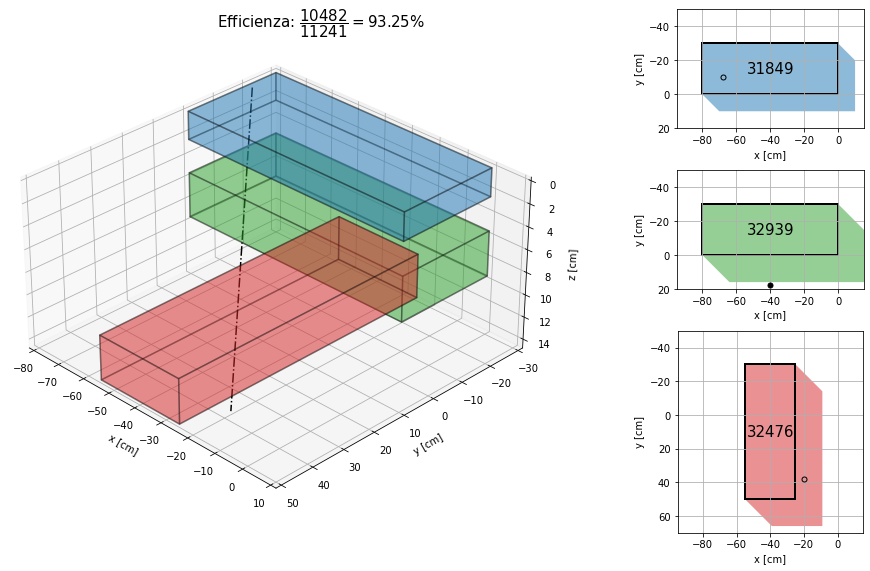

In [19]:
EventoDaVisualizzare = Evento(-78, -20, np.pi/2.37, np.pi/2.37)

# Retta rappresentante l'evento
x = np.array([EventoDaVisualizzare.x_ori, EventoDaVisualizzare.x_ori + Z_RIVELATORE[2] * np.tan(EventoDaVisualizzare.teta)])
y = np.array([EventoDaVisualizzare.y_ori, EventoDaVisualizzare.y_ori + Z_RIVELATORE[2] * np.tan(EventoDaVisualizzare.phi)])
z = np.array([EventoDaVisualizzare.z_ori, Z_RIVELATORE[2]])

#_FUNZIONI_GRAFICHE_____________________________________________________________________________________________________________________
# Funzione per creare un parallelepipedo in 3D
def DisegnaParallelogramma(parallelogramma):
    x, y, z = parallelogramma.x, parallelogramma.y, parallelogramma.z
    dx, dy, dz = parallelogramma.larghezza, parallelogramma.profondità, parallelogramma.altezza

    # Vertici del parallelepipedo
    vertices = [
        [x - dx, y - dy, z - dz ],
        [x,      y - dy, z - dz ],
        [x,      y,      z - dz ],
        [x - dx, y,      z - dz ],
        [x - dx, y - dy, z      ],
        [x,      y - dy, z      ],
        [x,      y,      z      ],
        [x - dx, y,      z      ],
    ]

    # Facce del parallelepipedo
    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[3], vertices[0], vertices[4], vertices[7]],
        [vertices[4], vertices[5], vertices[6], vertices[7]],
        [vertices[0], vertices[1], vertices[2], vertices[3]]
    ]

    return faces

# Funzione per creare il plot 3D da una determinata prospettiva
def PlotInProspettiva3D(ax, azimuth, elevation):   
    # Disegna i parallelepipedi dei rivelatori
    for iRivelatore, Rivelatore in enumerate(Rivelatori):
        faces = DisegnaParallelogramma(Rivelatore)
        poly3d = Poly3DCollection(faces, alpha=0.3, edgecolor='k', facecolor=COLORI_TRE[iRivelatore], linewidth=1.5)
        ax.add_collection3d(poly3d)

    # Disegna la retta
    ax.plot(x, y, z, color='k', linestyle='-.', linewidth=1.5)

    # Imposta i limiti del grafico
    ax.set_xlim([10, -80])
    ax.set_ylim([-30, 50])
    ax.set_zlim([Z_RIVELATORE[2], 0])  # Inverti l'asse Z
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_zlabel('z [cm]')
    ax.set_box_aspect([9, 9, 5])
    
    # Imposta la prospettiva
    ax.view_init(elev=elevation, azim=azimuth)

# Funzione per creare il plot delle aree efficaci di ciascun rivelatore
def PlotOmbre(axs):
    for iRivelatore, ax in enumerate(axs):

        #for EventoDaVisualizzare in Eventi:
        OmbraRivelatore = CalcolaOmbra(Rivelatori[iRivelatore], EventoDaVisualizzare)
        x, y = OmbraRivelatore.exterior.xy
    
        PuntoPassaggioEvento = Point(EventoDaVisualizzare.x[iRivelatore], EventoDaVisualizzare.y[iRivelatore])
        PuntoInterno = OmbraRivelatore.contains(PuntoPassaggioEvento)

        ax.fill(x, y, alpha=0.5, facecolor=COLORI_TRE[iRivelatore])
        ax.plot(PuntoPassaggioEvento.x, PuntoPassaggioEvento.y, 
                marker='o', markerfacecolor='none' if PuntoInterno  else 'k', markeredgecolor='k', markersize=5)
        
        # Aggiungi un rettangolo
        BaseRivelatore = patches.Rectangle(
                                           (Rivelatori[iRivelatore].x - Rivelatori[iRivelatore].larghezza, 
                                            Rivelatori[iRivelatore].y - Rivelatori[iRivelatore].profondità),
                                            Rivelatori[iRivelatore].larghezza, Rivelatori[iRivelatore].profondità,
                                            linewidth=2, edgecolor='k', facecolor='none'
                                          )
        ax.add_patch(BaseRivelatore)

        centro_x = Rivelatori[iRivelatore].x - Rivelatori[iRivelatore].larghezza/2
        centro_y =Rivelatori[iRivelatore].y - Rivelatori[iRivelatore].profondità/2
        ax.text(centro_x, centro_y, f"{SingolePerRivelatore[iRivelatore]}", 
                fontsize=FONT_DIM[1], ha='center', va='center')  # Testo centrato
    
        # Imposta i limiti e le etichette per ciascun subplot
        ax.set_xlim(-95, 15)
        #ax.set_xlim(X_RIVELATORE[iRivelatore] - LUNGHEZZA_RIVELATORE_X[iRivelatore] - 15, X_RIVELATORE[iRivelatore] + 15)
        ax.set_ylim(Y_RIVELATORE[iRivelatore] + 20, Y_RIVELATORE[iRivelatore] - LUNGHEZZA_RIVELATORE_Y[iRivelatore] - 20)
        ax.set_xlabel('x [cm]')
        ax.set_ylabel('y [cm]')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True)
#_______________________________________________________________________________________________________________________________________

fig = plt.figure(figsize=(15, 8))
gs = GridSpec(3, 2, height_ratios=[1, 1, 1.7], width_ratios=[1, 1], figure=fig)  # Griglia con 3 righe e 2 colonne

# Plot 3D a sinistra (spanning su tutte e tre le righe)
ax_sx = fig.add_subplot(gs[:, 0], projection='3d')  # Occupa tutte le righe della prima colonna
PlotInProspettiva3D(ax_sx, azimuth=135, elevation=30)

# Subplot delle ombre sulla destra
axs_dx = [fig.add_subplot(gs[i, 1]) for i in range(3)]  # Tre subplot nella seconda colonna
PlotOmbre(axs_dx)

# Testo con efficienza
fig.text(
    0.22, 0.95,
    f"Efficienza: $\\dfrac{{{Triple}}}{{{DoppiePerRivelatore[1]}}} = {Efficienze[1]*100:.2f}\\%$",
    fontsize=FONT_DIM[1]
)

# Mostra il grafico
plt.tight_layout()
plt.show()